In [1]:
import numpy as np
import pandas as pd
import scipy.spatial
import re
import gensim
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Label
from bokeh.io import output_notebook
from pprint import pprint
import seaborn as sns

# Load Data

In [2]:
dictionary = gensim.corpora.Dictionary.load('../clean-data/fine-scale/all-countries/dictionary.dict')
corpus = gensim.corpora.MmCorpus('../clean-data/fine-scale/all-countries/corpus.mm')
lda = gensim.models.ldamulticore.LdaMulticore.load('../models/fine-scale/all-countries/model_140_topics')

# Get topic word matrix

Top 10 words for each topic

In [3]:
#sns.set(rc={'figure.figsize':(15,15)})

topic_words = [[j[0] for j in lda.show_topic(i,topn = 15)] for i in range(lda.num_topics)]

topic_df = pd.DataFrame(topic_words)

print(topic_df.to_string())

len(corpus)

                   0                     1                    2                         3                    4                     5                   6                     7                       8                      9                     10                     11                        12                       13                   14
0               plant                  gene                trait                    specie           expression                  crop     gene_expression            resistance               variation               pathogen            population              evolution                      leaf                     tree             breeding
1              fixing                  york              droplet                  assembly        biotechnology               protein          condensate                carbon           liquid_liquid               dissolve            complexity                  algal                  membrane                   living  

273621

In [4]:
#distance matrix
d_mat = np.load("../results/fine-scale/all-countries/funder_distances.npy")
#funder names
with open("../results/fine-scale/all-countries/funder_index.txt") as f:
    funders = list(map(lambda x: x.strip(), f.readlines()))

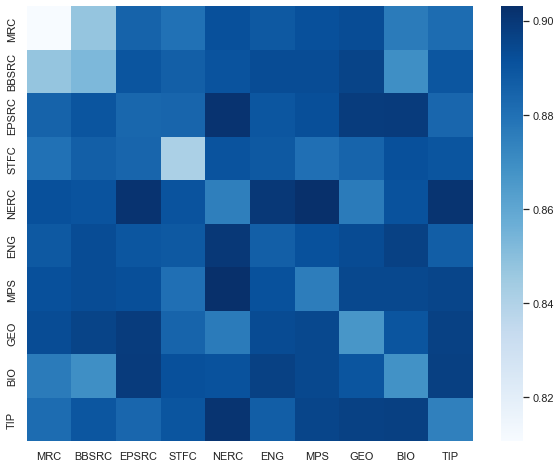

In [5]:
sns.set(rc={'figure.figsize':(10,8)})

a = sns.heatmap(np.nanmean(d_mat, axis = (2)), xticklabels=funders, yticklabels=funders, cmap = "Blues")


# plt.savefig('../results/fine-scale/figures/distances_fundingBody.png')

# Dendogram
## By research council

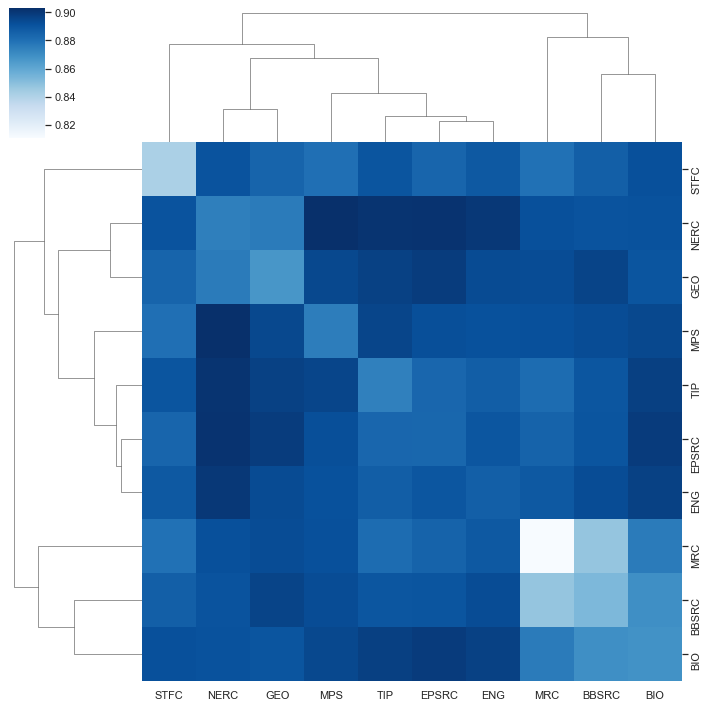

In [6]:
sns.set(rc={'figure.figsize':(15,15)})

#a = sns.heatmap(np.nanmean(d_mat, axis = (2)), xticklabels=funders, yticklabels=funders, cmap = "Blues")


sns.clustermap(np.nanmean(d_mat, axis = (2)), xticklabels=funders, yticklabels=funders, cmap = "Blues")


#plt.savefig('../results/fine-scale/figures/distances_fundingBody_dendogram_matrix.png')

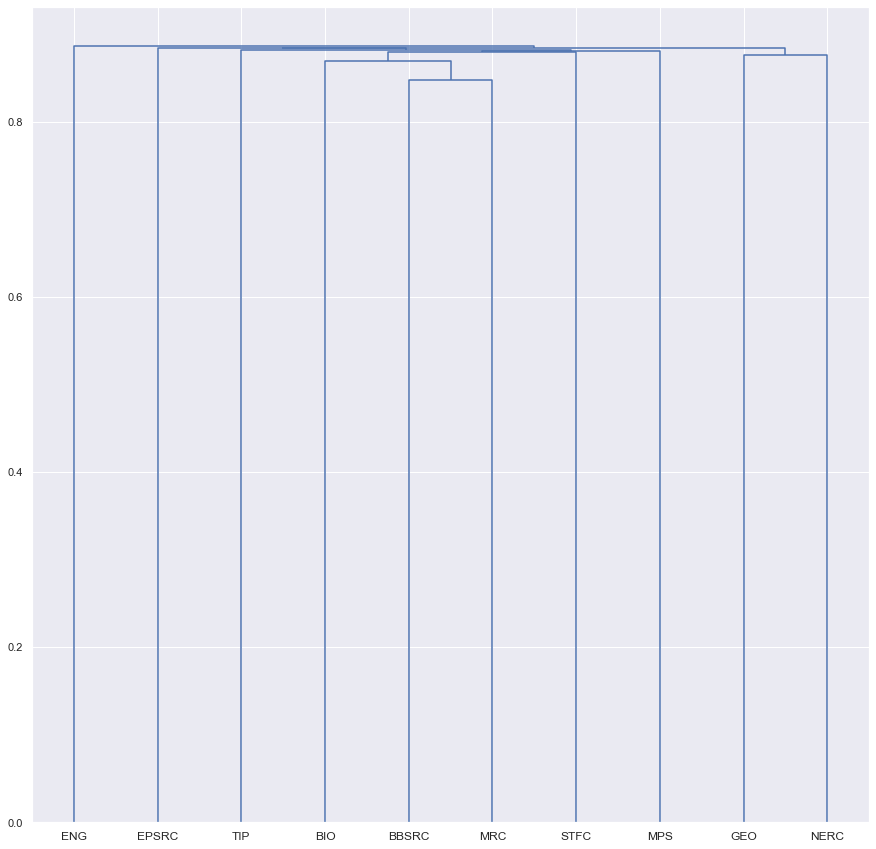

In [7]:
from scipy.spatial.distance import squareform 
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import fcluster

mat = np.nanmean(d_mat, axis = (2))
np.fill_diagonal(mat, 0)
mat = squareform(mat)

Z = linkage(mat, optimal_ordering=True)
fig = plt.figure(figsize=(15, 15))

dn = dendrogram(Z, labels = funders)

# plt.show()
# plt.savefig('../results/fine-scale/figures/distances_fundingBody_dendogram.pdf')

In [8]:
#distance matrix
d_mat_uni = np.load("../results/fine-scale/all-countries/university_distances.npy")
#funder names
with open("../results/fine-scale/all-countries/university_index.txt") as f:
    unis = list(map(lambda x: x.strip(), f.readlines()))

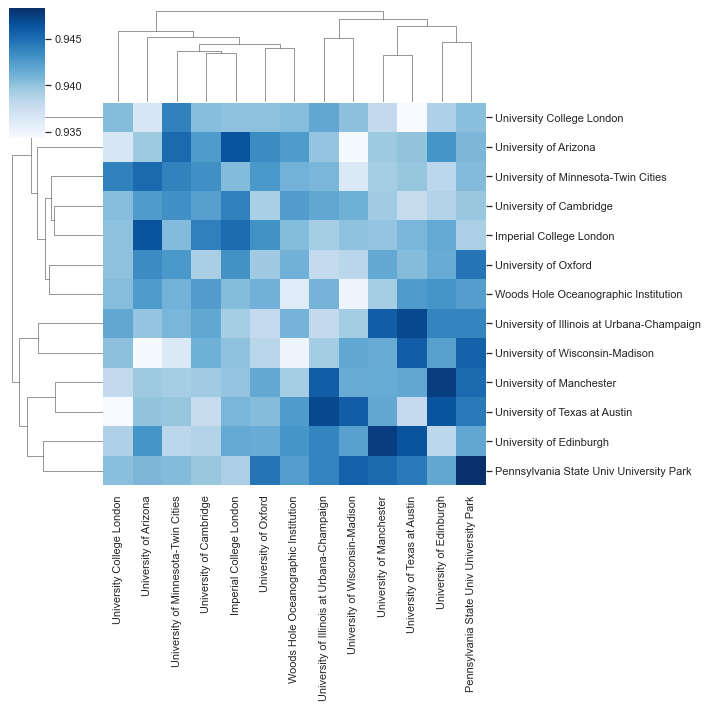

In [9]:
sns.set(rc={'figure.figsize':(10,8)})

sns.clustermap(np.nanmean(d_mat_uni, axis = (2)), xticklabels=unis, yticklabels=unis, cmap = "Blues")

plt.savefig('../results/fine-scale/figures/distances_university.png')

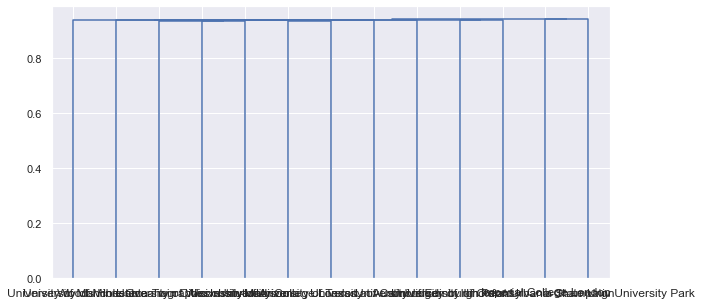

In [10]:
mat_uni = np.nanmean(d_mat_uni, axis = (2))
np.fill_diagonal(mat_uni, 0)
mat_uni = squareform(mat_uni)

Z_uni = linkage(mat_uni, optimal_ordering=True)
fig = plt.figure(figsize=(10, 5))

dn_uni = dendrogram(Z_uni, labels = unis)

# plt.show()
#plt.savefig('../results/fine-scale/figures/distances_universities_dendogram.pdf')

In [11]:
#distance matrix
d_mat_russell = np.load("../results/fine-scale/all-countries/university_distances_russell.npy")
#funder names
with open("../results/fine-scale/all-countries/university_index_russell.txt") as f:
    unis = list(map(lambda x: x.strip(), f.readlines()))

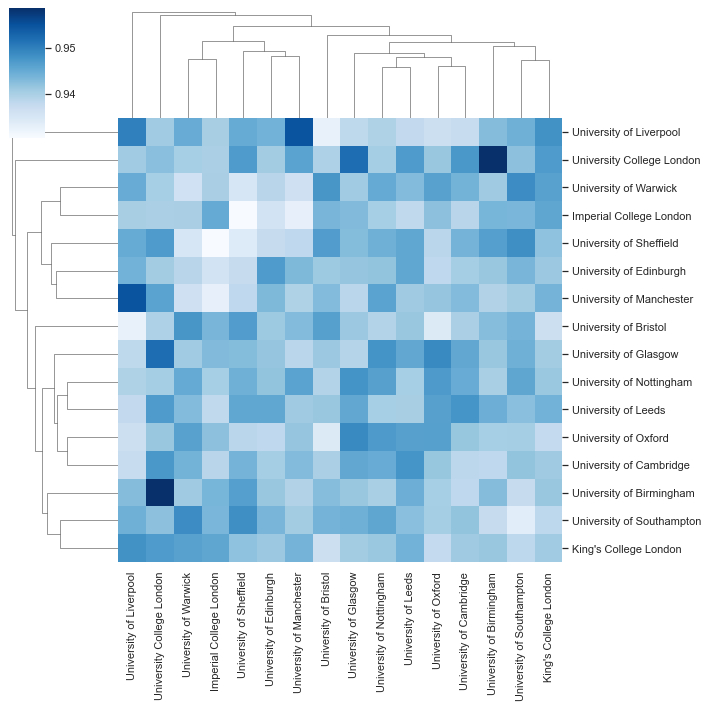

In [12]:
sns.set(rc={'figure.figsize':(10,8)})

sns.clustermap(np.nanmean(d_mat_russell, axis = (2)), xticklabels=unis, yticklabels=unis, cmap = "Blues")

plt.savefig('../results/fine-scale/figures/distances_university_russell.png')
plt.savefig('../results/fine-scale/figures/distances_university_russell.pdf')

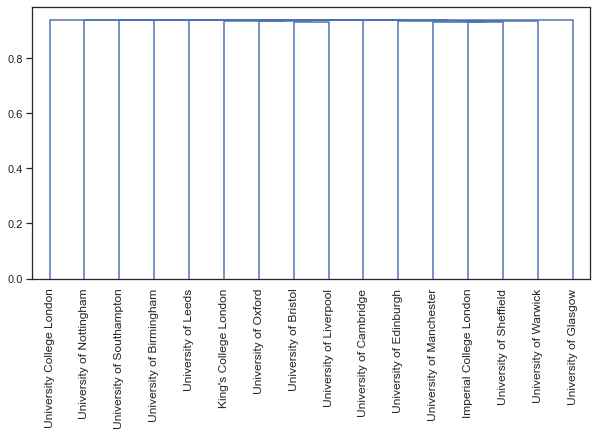

In [13]:
sns.set(rc={'figure.figsize':(30,15)})
sns.set_theme(style="ticks", font_scale=1.0)

mat_russell = np.nanmean(d_mat_russell, axis = (2))
np.fill_diagonal(mat_russell, 0)
mat_russell = squareform(mat_russell)

Z_russell = linkage(mat_russell, optimal_ordering=True)
fig = plt.figure(figsize=(10, 5))

dn_russell = dendrogram(Z_russell, labels = unis)
plt.xticks(rotation=90)

# plt.show()
plt.savefig('../results/fine-scale/figures/distances_RussellGroup_dendrogram.pdf')

# TSNE data frame


In [14]:
#load dataframe
tsne_df = pd.read_csv("../results/fine-scale/all-countries/tsne_full_df.csv")

#pivot perplexity
per_list = [30, 50, 70, 90, 110, 200]

for i in per_list:
    tsne_df[str(i)] = tsne_df["tsne_ax1_"+str(i)].astype("str") + " " +tsne_df["tsne_ax2_"+str(i)].astype("str")
    
cols = ["tsne_ax1_"+str(i) for i in per_list] + ["tsne_ax2_"+str(i) for i in per_list]

tsne_df = tsne_df.drop(columns=cols).melt(id_vars = tsne_df.columns[1:12], value_vars = map(str, per_list))

tsne_df[["ax1","ax2"]] = tsne_df.value.str.split(" ", expand = True).astype("float32")

tsne_df = tsne_df.assign(Imperial = tsne_df.LeadInstitution == "Imperial College London")

tsne_df = tsne_df.assign(UKRI = tsne_df.CountryFundingBody == "UKRI")

#add max_topics
#read doc_topic
doc_topic = np.load("../results/fine-scale/all-countries/doc_topic_mat.npy")
#get max topic
topic_max_vec = np.argmax(doc_topic, axis = (0))

tsne_df["Topic"] = topic_max_vec[tsne_df.CorpusId]


tsne_df = tsne_df.query("variable == '110'")
tsne_df.head() 
tsne_df.count()

/var/folders/wv/tv9tdvts6m9fg377j70xphym0000gn/T/ipykernel_25631/1682922861.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  tsne_df = pd.read_csv("../results/fine-scale/all-countries/tsne_full_df.csv")


ProjectId             273621
Country               273621
CountryFundingBody    273621
CorpusId              273621
index                 273621
FundingBody           273621
LeadInstitution       273621
StartDate             273621
EndDate               273617
FundingAmount         273598
FundingCurrency       273621
variable              273621
value                 273621
ax1                   273621
ax2                   273621
Imperial              273621
UKRI                  273621
Topic                 273621
dtype: int64

In [15]:
tsne_df.columns

Index(['ProjectId', 'Country', 'CountryFundingBody', 'CorpusId', 'index',
       'FundingBody', 'LeadInstitution', 'StartDate', 'EndDate',
       'FundingAmount', 'FundingCurrency', 'variable', 'value', 'ax1', 'ax2',
       'Imperial', 'UKRI', 'Topic'],
      dtype='object')

In [16]:
tsne_df.query("Country == 'USA'").StartDate.min()
# tsne_df.query("StartDate == '01/01/1983'")

'01/01/1985'

In [17]:
russell_group = pd.Series(["University of Birmingham", "University of Bristol", "University of Cambridge", "Cardiff University", "Durham University", "University of Edinburgh", "University of Exeter", 
"University of Glasgow", "Imperial College London", "King's College London", "University of Leeds", "University of Liverpool", "London School of Economics and Political Science", 
"University of Manchester", "Newcastle University", "University of Nottingham", "University of Oxford", "Queen Mary University of London", "Queen’s University Belfast", "University of Sheffield", 
"University of Southampton", "University College London", "University of Warwick", "University of York"])

tsne_df["RussellGroup"] = tsne_df["LeadInstitution"].isin(russell_group)
# tsne_df = tsne_df.assign(Imperial = tsne_df.LeadInstitution == russel_group)
tsne_df.head()

ProjectId Country CountryFundingBody  \
1094484  C863601C-4645-4020-914E-3C572106BB23      UK               UKRI   
1094485  C1B1FA74-D748-451F-A74C-9EDE41BF7EE3      UK               UKRI   
1094486  73CCF222-0616-4CE8-8BFD-8738EBED8513      UK               UKRI   
1094487  D2FDCD7F-77ED-4434-ACAC-2419E5232F14      UK               UKRI   
1094488  17555E0B-B1D0-45E3-ABBC-568398B51F03      UK               UKRI   

         CorpusId  index FundingBody                          LeadInstitution  \
1094484         0  14139         MRC                     University of Oxford   
1094485         1  45356       BBSRC               The James Hutton Institute   
1094486         2  34003       EPSRC                University of Southampton   
1094487         3  39368       EPSRC                  University of Edinburgh   
1094488         4  31117         MRC  London Sch of Hygiene and Trop Medicine   

          StartDate     EndDate  FundingAmount FundingCurrency variable  \
1094484  30/04/2013  29/04/2016      1274897.0             GBP      110   
1094485  30/09/2012  30/03/2016       115747.0             GBP      110   
1094486  10/01/2011  09/01/2015       916817.0             GBP      110   
1094487  31/08/2009  30/08/2010        86434.0             GBP      110   
1094488  26/01/2015  30/03/2017        50405.0             GBP      110   

                         value        ax1         ax2  Imperial  UKRI  Topic  \
1094484    -62.331676 19.59747 -62.331676   19.597469     False  True     81   
1094485    -42.04772 66.540886 -42.047722   66.540886     False  True     89   
1094486  -7.9740887 -48.668095  -7.974089  -48.668095     False  True     95   
1094487    10.093515 -103.5654  10.093515 -103.565399     False  True     94   
1094488     17.384256 9.571398  17.384256    9.571398     False  True     65   

         RussellGroup  
1094484          True  
1094485         False  
1094486          True  
1094487          True  
1094488         False

In [18]:
len(russell_group)

24

# Histograms
## projects by country

<AxesSubplot:xlabel='Topic', ylabel='Density'>

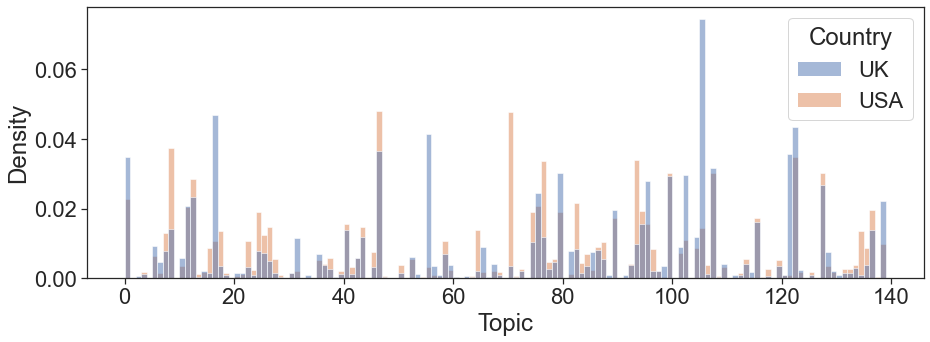

In [19]:
sns.set(rc={'figure.figsize':(15,5)})

sns.set_theme(style="ticks", font_scale=2.0)

sns.histplot(data=tsne_df, x='Topic', hue = 'Country', stat='density', common_norm=False, binwidth = 1)


# 10 most funded topics

In [20]:
most_funded = tsne_df.groupby(['Country', 'Topic']).size().to_frame('size').reset_index().sort_values(["size"], ascending=False).groupby(['Country']).head(5)
most_funded =  most_funded.set_index('Topic').join(topic_df)

word_cols = [i for i in range(10)]
most_funded['combined'] = most_funded[word_cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
most_funded = most_funded.drop(word_cols, axis = 1).sort_values("size", ascending = False)
most_funded = most_funded.rename(columns={'size':'Number of projects'})

most_funded.to_csv("../results/fine-scale/all-countries/most_funded.csv", index = False)


In [44]:
most_funded = tsne_df.groupby(['Country', 'Topic']).size().reset_index().sort_values([0], ascending=False).groupby(['Country']).head(30)
# a.query('Topic == 16')
most_funded.query("Country == 'USA'")

Country  Topic      0
167     USA     46  10789
189     USA     70  10774
134     USA      8   8436
239     USA    122   7834
210     USA     93   7636
194     USA     76   7558
216     USA     99   6833
224     USA    107   6794
243     USA    127   6779
137     USA     12   6419
128     USA      0   5129
200     USA     82   4876
193     USA     75   4641
136     USA     11   4625
252     USA    136   4412
211     USA     94   4347
192     USA     74   4302
197     USA     79   4284
148     USA     24   4284
207     USA     89   3910
232     USA    115   3870
212     USA     95   3540
162     USA     40   3521
165     USA     43   3339
150     USA     26   3298
222     USA    105   3223
183     USA     64   3135
250     USA    134   3045
142     USA     17   3028
133     USA      7   2923

# 10 least funded topics

In [22]:
least_funded = tsne_df.groupby(['Country', 'Topic']).size().reset_index().sort_values([0], ascending=False).groupby(['Country']).tail(20)
least_funded.query("Country == 'UK'").sort_values([0])

Country  Topic   0
107      UK    118   1
60       UK     69   2
92       UK    103   3
27       UK     32   5
105      UK    116   7
70       UK     80   8
125      UK    137   9
99       UK    110   9
45       UK     54  10
52       UK     61  11
113      UK    124  11
41       UK     49  11
89       UK    100  11
57       UK     66  14
10       UK     13  14
62       UK     71  15
97       UK    108  15
32       UK     38  15
51       UK     60  19
54       UK     63  21

## projects in the UK by Imperial

<AxesSubplot:xlabel='Topic', ylabel='Count'>

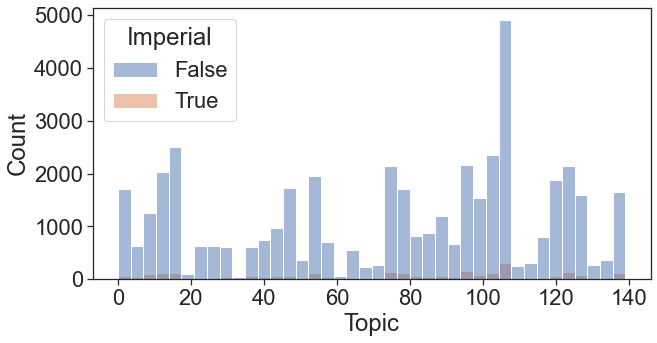

In [23]:
sns.set(rc={'figure.figsize':(10,5)})

sns.set_theme(style="ticks", font_scale=2.0)

sns.histplot(data=tsne_df.query("Country == 'UK'"), x='Topic', hue = 'Imperial')

In [24]:
imperial = tsne_df.groupby(['Imperial', 'Topic']).size().reset_index().sort_values([0], ascending=False).groupby(['Imperial']).head(10)
imperial.query("Imperial == True")

Imperial  Topic    0
210      True    105  205
169      True     55  122
222      True    122  122
202      True     95  103
140      True     16  100
212      True    107   93
188      True     79   92
136      True     11   73
205      True     99   72
163      True     46   65

In [25]:
tsne_df.groupby(['Imperial', 'Topic']).size().reset_index().sort_values([0], ascending=False).groupby(['Imperial']).tail(10)

Imperial  Topic   0
70      False     80  39
41      False     49  39
89      False    100  36
52      False     61  35
60      False     69  28
92      False    103  23
27      False     32  23
113     False    124  19
32      False     38  17
107     False    118   4
208      True    103   1
164      True     47   1
224      True    125   1
174      True     63   1
168      True     54   1
203      True     96   1
215      True    112   1
171      True     57   1
213      True    108   1
178      True     68   1

## Number of projects per country

In [26]:
# get number of universities per country
n_institution = tsne_df.groupby("Country")["LeadInstitution"].agg('count').reset_index()
n_institution
# divide number of research proposals by number of universitites per country

Country  LeadInstitution
0      UK            48527
1     USA           225094

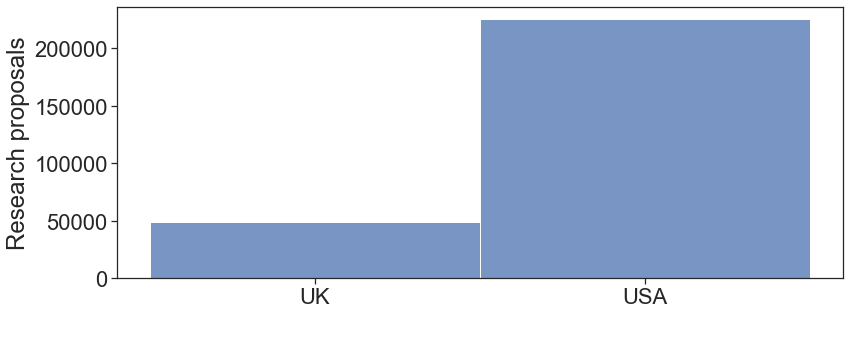

In [27]:
sns.set(rc={'figure.figsize':(13,5)})

sns.set_theme(style="ticks", font_scale=2.0)

a = sns.histplot(data=tsne_df, x='Country')
a.set(xlabel=' ', ylabel='Research proposals')

plt.savefig('../results/fine-scale/figures/hist_UK_vs_USA.png')

## Funding allocated by country

In [28]:
tsne_df_awards = tsne_df.query("FundingAmount > 0", engine='python')

In [29]:
tsne_df_awards = tsne_df_awards.assign(Funding = lambda x : x.FundingAmount.astype(float) * ((x.FundingCurrency == "USD") * 0.84 + (x.FundingCurrency != "USD")))
tsne_df_awards["log10_funding"] = np.log10(tsne_df_awards.Funding)

tsne_df_awards = tsne_df_awards.query("log10_funding > 2").query("log10_funding < 10")

# tsne_df_awards["relative_funding"] = tsne_df_awards.groupby(['Country'], group_keys=False).Funding.transform(lambda x: x / sum(x))

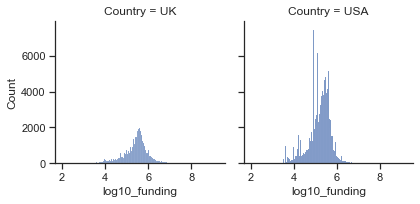

In [30]:
sns.set(rc={'figure.figsize':(10,10)})
sns.set_theme(style="ticks", font_scale=1.0)

g = sns.FacetGrid(tsne_df_awards, col="Country")
g.map(sns.histplot, "log10_funding")

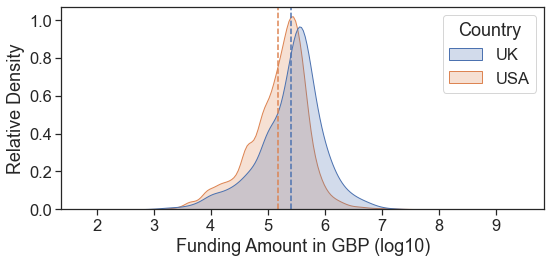

In [31]:
sns.set(rc={'figure.figsize':(8,4)})

sns.set_theme(style="ticks", font_scale=1.5)

b = sns.kdeplot(data=tsne_df_awards, x="log10_funding", hue = 'Country', fill = True, common_norm=False, bw_adjust= 2.0)
b.set(xlabel='Funding Amount in GBP (log10)')
b.set(ylabel='Relative Density')

mean_UK = tsne_df_awards.query("Country == 'UK'")['log10_funding'].mean()
median_UK = tsne_df_awards.query("Country == 'UK'")['log10_funding'].median()

mean_USA = tsne_df_awards.query("Country == 'USA'")['log10_funding'].mean()
median_USA = tsne_df_awards.query("Country == 'USA'")['log10_funding'].median()

line_1 = plt.axvline(mean_UK, color = sns.color_palette()[0]).set_linestyle('--')
line_2 = plt.axvline(mean_USA, color = sns.color_palette()[1]).set_linestyle('--')

b.figure.tight_layout()

plt.savefig('../results/fine-scale/figures/hist_UK_vs_USA_funding.png')

In [52]:
tsne_df_awards.query("Country == 'UK'")['FundingAmount'].sum()

27071566114.0

In [53]:
tsne_df_awards.query("Country == 'UK'").query("Imperial == True")['FundingAmount'].sum()

1696906661.0

In [57]:
1696906661/(27071566114+101417913109)

0.013206580579682579

In [58]:
1696906661/27071566114

0.062682249481032

In [56]:
tsne_df_awards.query("Country == 'USA'")['FundingAmount'].sum()

101417913109.0

In [32]:
from scipy.stats import ttest_ind

# CALCULATE T-TEST
#define samples
group1 = tsne_df_awards[tsne_df_awards['Country']=='UK']
group2 = tsne_df_awards[tsne_df_awards['Country']=='USA']

#perform independent two sample t-test
ttest_ind(group1['log10_funding'], group2['log10_funding'],equal_var = False)

Ttest_indResult(statistic=77.036146204654, pvalue=0.0)

# Plotting TSNE

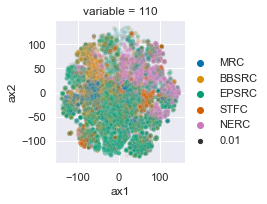

In [33]:
sns.set(rc={'figure.figsize':(15,15)})

g = sns.FacetGrid(tsne_df.query("Country == 'UK'"), col= "variable", sharex = False, sharey = False)
g.map_dataframe(sns.scatterplot, x="ax1", y = "ax2", hue = "FundingBody", alpha = 0.1, size = 0.01,palette="colorblind")
g.add_legend()

# By max topic

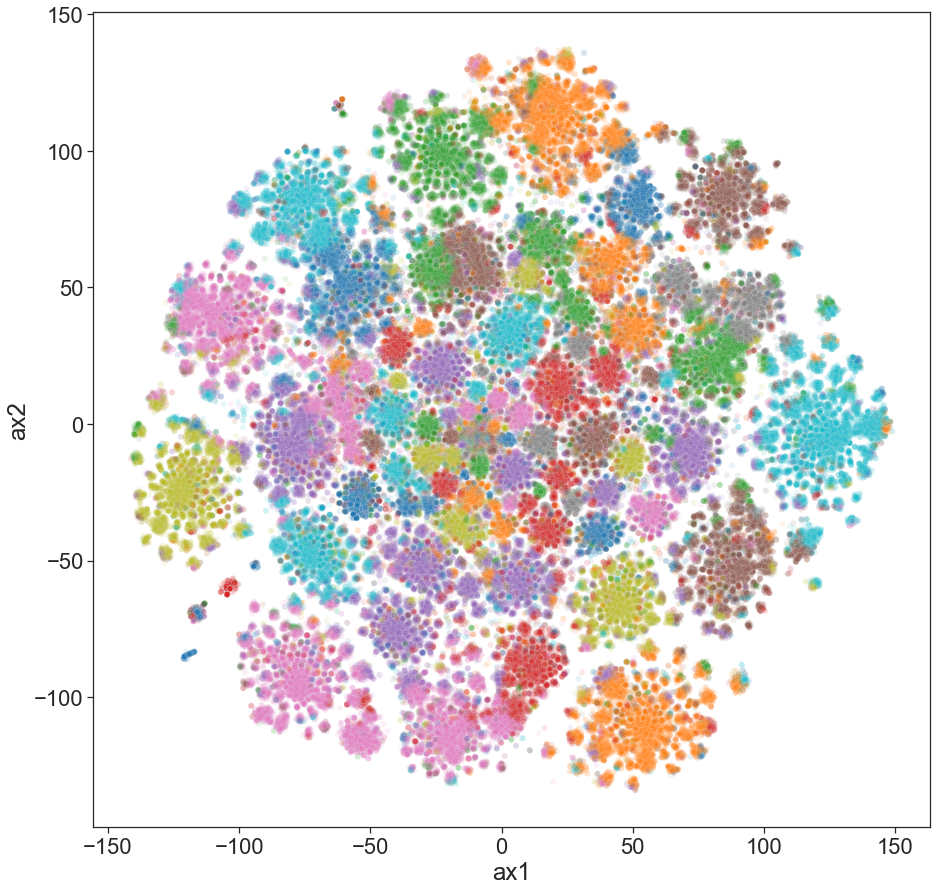

In [34]:
sns.set(rc={'figure.figsize':(15,15)})

sns.set_theme(style="ticks", font_scale=2.0)

g = sns.scatterplot(x = "ax1", y = "ax2", 
                data = tsne_df,
                hue = "Topic",
                palette = "tab10",
                alpha = 0.1)
g.legend_.remove()

# Only UK topic space

<AxesSubplot:xlabel='ax1', ylabel='ax2'>

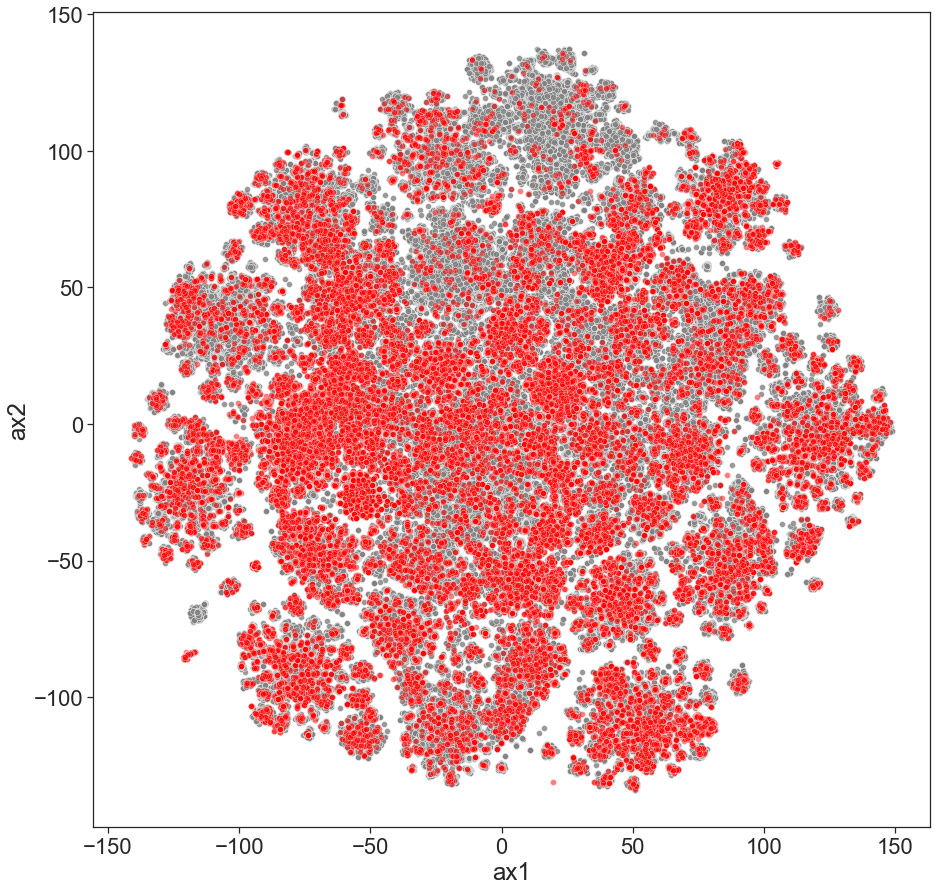

In [35]:
sns.set(rc={'figure.figsize':(15,15)})

sns.set_theme(style="ticks", font_scale=2.0)

sns.scatterplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("variable == '110'").query("UKRI == False"),
                color = "grey",
                alpha = 0.8)

sns.scatterplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("variable == '110'").query("UKRI == True"),
                color = "red",
                alpha = 0.5)

#plt.savefig('../results/fine-scale/figures/tsne_UK_only.png')

# Only USA topic space


<AxesSubplot:xlabel='ax1', ylabel='ax2'>

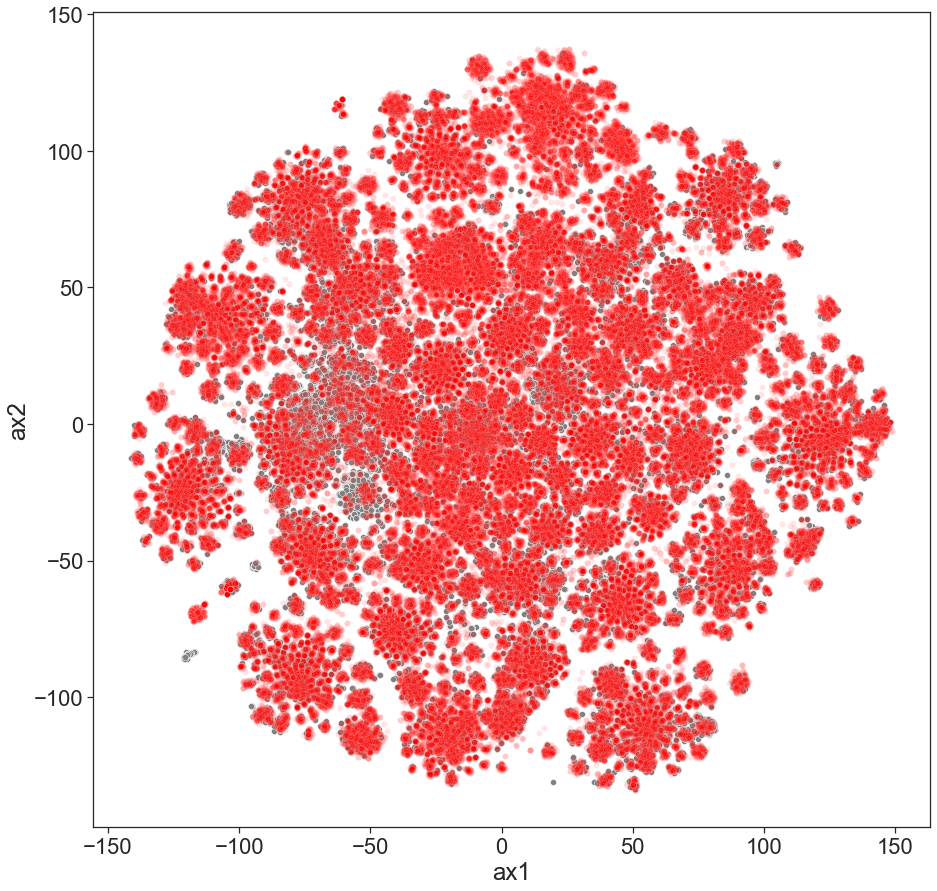

In [36]:
sns.set(rc={'figure.figsize':(15,15)})

sns.set_theme(style="ticks", font_scale=2.0)

sns.scatterplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("variable == '110'").query("UKRI == True"),
                color = "grey",
                alpha = 1)

sns.scatterplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("variable == '110'").query("UKRI == False"),
                color = "red",
                alpha = 0.1)

#plt.savefig('../results/fine-scale/figures/tsne_USA_only.png')

# By UKRI and USA research councils - grid

country: UK   funding body: BBSRC
country: USA   funding body: BIO
country: UK   funding body: MRC
country: USA   funding body: ENG
country: UK   funding body: EPSRC
country: USA   funding body: TIP
country: UK   funding body: STFC
country: USA   funding body: MPS
country: UK   funding body: NERC
country: USA   funding body: GEO


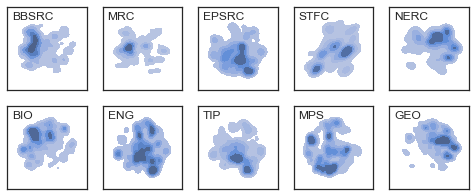

In [19]:
#get countries
countries = ["UK","USA"]

fundingbodies = [[],[]]
fundingbodies[0] = ["BBSRC","MRC","EPSRC","STFC","NERC"]
fundingbodies[1] = ["BIO","ENG","TIP","MPS","GEO"]

cm = 1/2.54
f, axs = plt.subplots(2,5, figsize = (21* cm ,8.5*cm))

for i in range(5):
    for j in range(2):
        
        print("country: " + countries[j], "  funding body: " + fundingbodies[j][i])
        #plot
        x = sns.kdeplot(data=  tsne_df.query("variable == '110'").query("FundingBody == '" + fundingbodies[j][i] + "'"),
                       x="ax1", y="ax2",
                        levels = 6,
                       fill=True,
                       #alpha=0.5,
                        ax=axs[j,i])

        x.annotate(fundingbodies[j][i], [-175,140], fontsize= 12)
        
        #remove axis elements
        axs[j,i].set_xlim(-200, 200)
        axs[j,i].set_ylim(-200, 200)
        x.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
        x.tick_params(bottom = False, left = False)

plt.savefig('../results/fine-scale/figures/tsne_density_FundingBodies.png')

# By NSF research councils

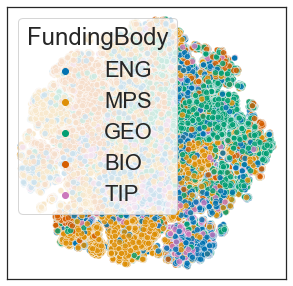

In [38]:
sns.set(rc={'figure.figsize':(5,5)})

sns.set_theme(style="ticks", font_scale=2.0)

x = sns.scatterplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("variable == '110'").query("UKRI == False"),
                hue = "FundingBody",
                palette = "colorblind",
                alpha = 0.8)

x.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
x.tick_params(bottom = False, left = False)
    
# plt.savefig('../results/fine-scale/figures/tsne_NSF_only.png')

## By UKRI research councils

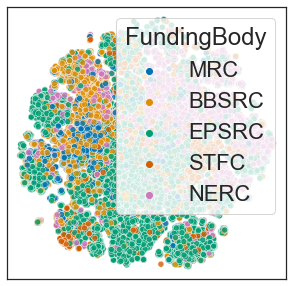

In [39]:
sns.set(rc={'figure.figsize':(5,5)})

sns.set_theme(style="ticks", font_scale=2.0)

x = sns.scatterplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("variable == '110'").query("UKRI == True"),
                hue = "FundingBody",
                palette = "colorblind",
                alpha = 0.8)

x.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
x.tick_params(bottom = False, left = False)
    
# plt.savefig('../results/fine-scale/figures/tsne_UKRI_only.png')

# By Imperial in the UK

In [47]:
tsne_df.columns

Index(['ProjectId', 'Country', 'CountryFundingBody', 'CorpusId', 'index',
       'FundingBody', 'LeadInstitution', 'StartDate', 'EndDate',
       'FundingAmount', 'FundingCurrency', 'variable', 'value', 'ax1', 'ax2',
       'Imperial', 'UKRI', 'Topic', 'RussellGroup'],
      dtype='object')

<AxesSubplot:xlabel='ax1', ylabel='ax2'>

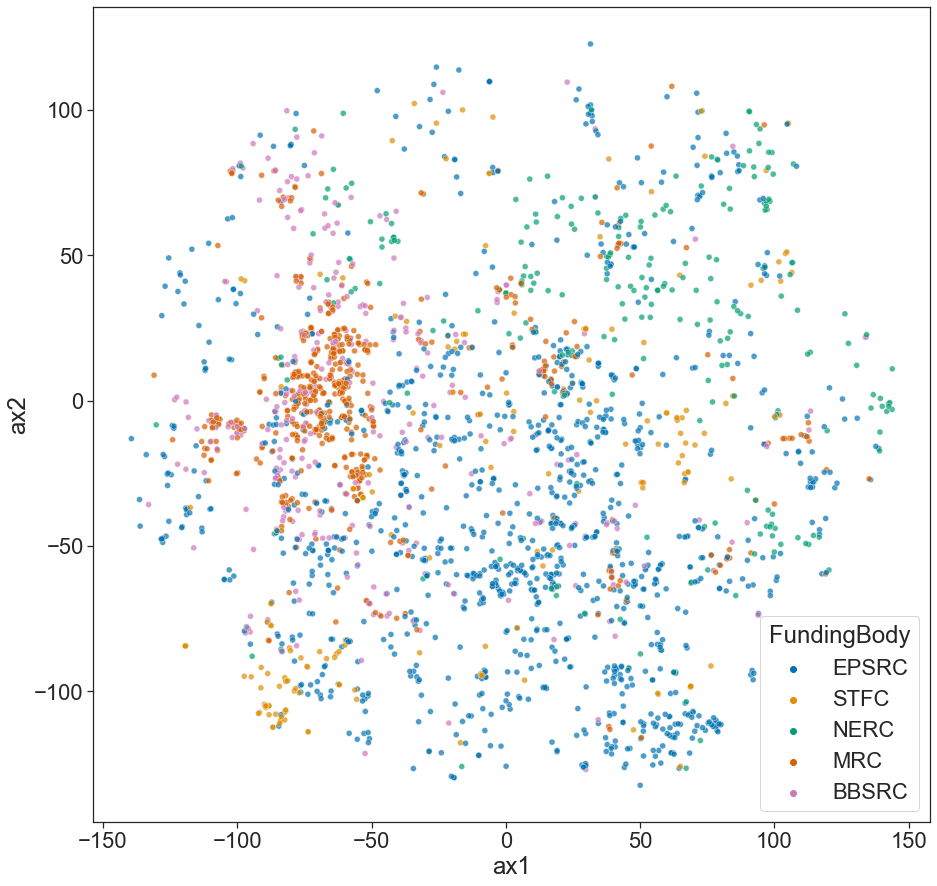

In [51]:
sns.set(rc={'figure.figsize':(15,15)})

sns.set_theme(style="ticks", font_scale=2.0)

fig, ax = plt.subplots()

sns.scatterplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("variable == '110'").query("Imperial == True").query("Country == 'UK'"),
                palette = "colorblind",
                hue = "FundingBody",
                alpha = 0.7,
                ax = ax)

# sns.scatterplot(x = "ax1", y = "ax2", 
#                 data = tsne_df.query("variable == '110'").query("Imperial == True"),
#                 color = "red",
#                 alpha = 0.8,
#                 ax = ax)

# plt.savefig('../results/fine-scale/figures/tsne_Imperial_UK.png')

# By Imperial in the world

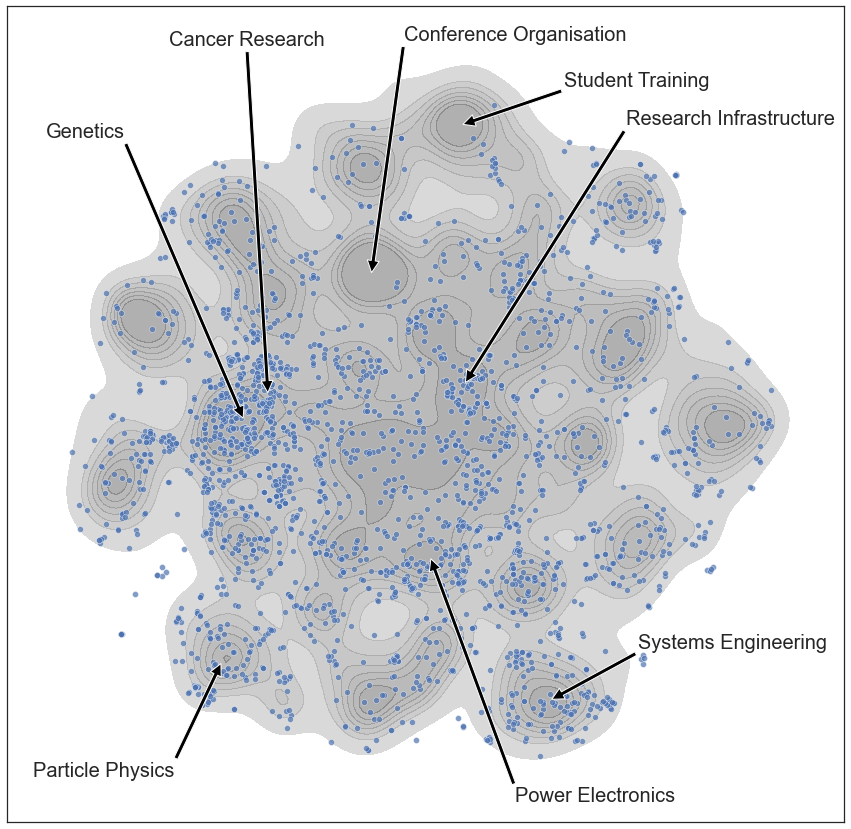

In [45]:
sns.set(rc={'figure.figsize':(15,15)})

sns.set_theme(style="ticks", font_scale=1.8)


g = sns.kdeplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("variable == '110'"),
                color = "grey",
                levels = 8,
                alpha = 0.5,
                fill = True)

g = sns.scatterplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("variable == '110'").query("Imperial == True"),
                # hue = "Topic",
                # palette = "colorblind",
                color =sns.color_palette()[0],
                alpha = 0.7,
                # label= "Imperial College London"
                   )

# g = sns.kdeplot(data= tsne_df.query("variable == '110'").query("Imperial == True"),
#                        x="ax1", y="ax2",
#                        levels = 6
#                )

g.annotate("Genetics", xy=(-70,0), xytext=(-150,110), fontsize= 20,arrowprops=dict(facecolor='black',connectionstyle="arc3,rad=0"))
g.annotate("Cancer Research", xy=(-60,10), xytext=(-100,146), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Systems Engineering", xy=(55,-110), xytext=(90,-90), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Power Electronics", xy=(6,-55), xytext=(40,-150), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Particle Physics", xy=(-79,-96), xytext=(-155,-140), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Research Infrastructure", xy=(20,14), xytext=(85,115), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Student Training", xy=(19,115), xytext=(60,130), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))
g.annotate("Conference Organisation", xy=(-18,57), xytext=(-5,148), fontsize= 20,arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0"))


g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
g.tick_params(bottom = False, left = False)

plt.savefig('../results/fine-scale/figures/tsne_density_imperial_topics.pdf')
plt.savefig('../results/fine-scale/figures/tsne_density_imperial_topics.png')

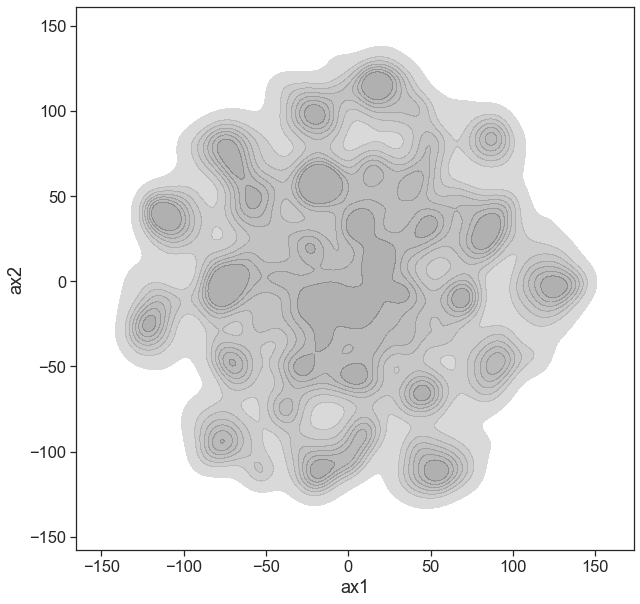

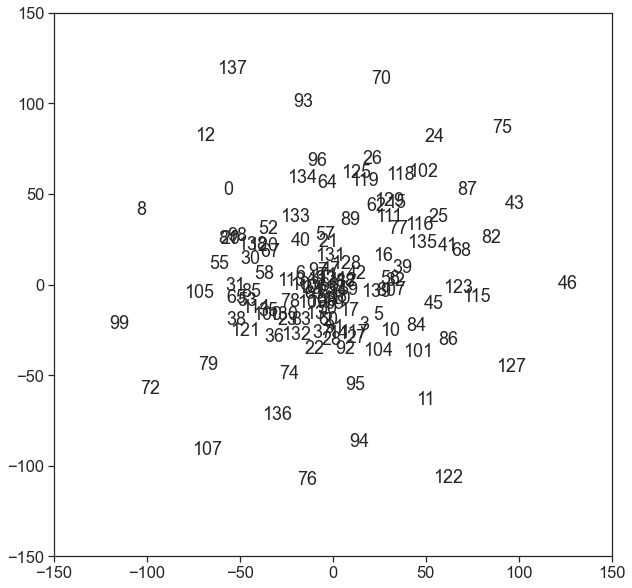

In [86]:
topic_centers = tsne_df.query("variable == '110'").query("Imperial == False").groupby("Topic").agg(x = ("ax1","median"), y = ("ax2","median"))

lim = 150
fig = plt.figure()

plt.axis([-lim,lim,-lim,lim])
for i in range(topic_centers.shape[0]):
    plt.text(topic_centers.x.iloc[i], topic_centers.y.iloc[i], topic_centers.index[i])


# By Imperial within UKRI

In [497]:
tsne_df.columns

Index(['ProjectId', 'Country', 'CountryFundingBody', 'CorpusId', 'index',
       'FundingBody', 'LeadInstitution', 'StartDate', 'EndDate',
       'FundingAmount', 'FundingCurrency', 'variable', 'value', 'ax1', 'ax2',
       'Imperial', 'UKRI', 'Topic', 'RussellGroup'],
      dtype='object')

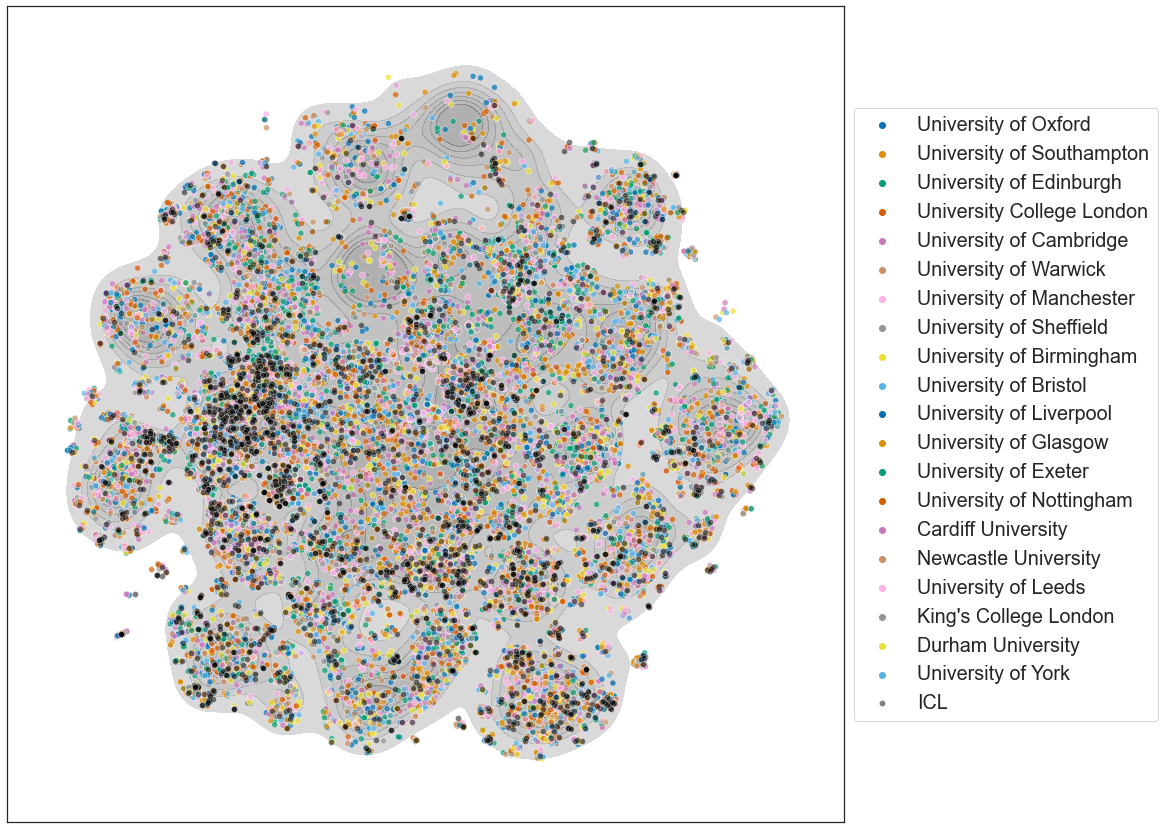

In [58]:
sns.set(rc={'figure.figsize':(15,15)})

sns.set_theme(style="ticks", font_scale=1.8)


g = sns.kdeplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("variable == '110'"),
                color = "grey",
                levels = 8,
                alpha = 0.5,
                fill = True)

g = sns.scatterplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("variable == '110'").query("RussellGroup == True").query("Imperial == False"),
                hue = "LeadInstitution",
                palette = "colorblind",
                alpha = 0.7,
                   )

g = sns.scatterplot(x = "ax1", y = "ax2", 
                data = tsne_df.query("variable == '110'").query("Imperial == True"),
                color = "black",
                label = "ICL",
                alpha = 0.5)

g.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
g.tick_params(bottom = False, left = False)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))



plt.savefig('../results/fine-scale/figures/tsne_density_RussellGroup.pdf')
plt.savefig('../results/fine-scale/figures/tsne_density_RussellGroup.png')

In [59]:
tsne_df_TopRussellGroup = tsne_df.query("variable == '110'").query("RussellGroup == True").groupby("LeadInstitution").filter(lambda x : len(x) > 1000)

try to sort by descending order of number of projects funded by Institutions

In [60]:
TSNE_uni_filter = tsne_df_TopRussellGroup.groupby('LeadInstitution').agg({'LeadInstitution': 'count'})
TSNE_uni_filter = TSNE_uni_filter.rename(columns={"LeadInstitution": "total_projects"})

TSNE_uni_filter = TSNE_uni_filter.sort_values(by="total_projects", ascending=False)
TSNE_uni_filter
#tsne_df.join(TSNE_uni_filter)

# df_meta_TSNE_uni_filter.sort_values(by="LeadInstitution", ascending=False)

total_projects
LeadInstitution                          
University College London            2753
University of Oxford                 2688
Imperial College London              2573
University of Cambridge              2492
University of Manchester             2211
University of Edinburgh              2044
University of Bristol                1622
University of Leeds                  1435
University of Sheffield              1373
University of Nottingham             1306
University of Birmingham             1269
University of Southampton            1228
University of Glasgow                1200
King's College London                1168
University of Liverpool              1120
University of Warwick                1071

In [169]:
tsne_df['LeadInstitution'] = tsne_df['LeadInstitution'].str.replace(r"[\"\']", '')

/var/folders/wv/tv9tdvts6m9fg377j70xphym0000gn/T/ipykernel_1320/819314174.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  tsne_df['LeadInstitution'] = tsne_df['LeadInstitution'].str.replace(r"[\"\']", '')


/var/folders/wv/tv9tdvts6m9fg377j70xphym0000gn/T/ipykernel_25631/1690951777.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  tsne_df['LeadInstitution'] = tsne_df['LeadInstitution'].str.replace(r"[\"\']", '')


 university: University College London
 university: University of Oxford
 university: Imperial College London
 university: University of Cambridge
 university: University of Manchester
 university: University of Edinburgh
 university: University of Bristol
 university: University of Leeds
 university: University of Sheffield
 university: University of Nottingham
 university: University of Birmingham
 university: University of Southampton
 university: University of Glasgow
 university: Kings College London
 university: University of Liverpool
 university: University of Warwick


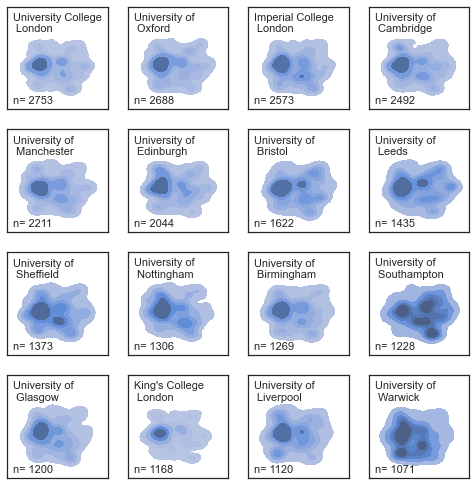

In [20]:
tsne_df['LeadInstitution'] = tsne_df['LeadInstitution'].str.replace(r"[\"\']", '')

unis = ["University College London", "University of Oxford", "Imperial College London", "University of Cambridge","University of Manchester", "University of Edinburgh","University of Bristol", "University of Leeds", "University of Sheffield",
       "University of Nottingham", "University of Birmingham", "University of Southampton", "University of Glasgow", "Kings College London", "University of Liverpool", "University of Warwick" ]
title = ["University College\n London", "University of\n Oxford", "Imperial College\n London", "University of\n Cambridge","University of\n Manchester", "University of\n Edinburgh","University of\n Bristol", "University of\n Leeds", 
         "University of\n Sheffield", "University of\n Nottingham", "University of\n Birmingham", "University of\n Southampton", "University of\n Glasgow", 'King\'s College\n London', "University of\n Liverpool", "University of\n Warwick"]
number_proj=["n= 2753", "n= 2688", "n= 2573", "n= 2492","n= 2211", "n= 2044","n= 1622", "n= 1435","n= 1373", "n= 1306", "n= 1269", "n= 1228", "n= 1200", "n= 1168", "n= 1120", "n= 1071"]

cm = 1/2.54
f, axs = plt.subplots(4,4, figsize = (21.02* cm ,22.02*cm))

for i in range(16):
        
    print(" university: " + unis[i])
    #plot
    # coord = [0 + (i > 3) + (i > 7) + (i > 11), i % 4]

    x = sns.kdeplot(data=  tsne_df.query("variable == '110'").query("LeadInstitution == '" + unis[i] + "'"),
                    x="ax1", y="ax2",
                    levels = 6,
                    fill=True,
                    ax=axs[0 + (i > 3) + (i > 7) + (i > 11), i % 4])

    x.annotate(title[i], [-175,140], fontsize= 11)
    x.annotate(number_proj[i], [-175,-175], fontsize = 11)
        
    #remove axis elements
    axs[0 + (i > 3) + (i > 7) + (i > 11), i % 4].set_xlim(-200, 200)
    axs[0 + (i > 3) + (i > 7) + (i > 11), i % 4].set_ylim(-200, 250)
    x.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel = None)
    x.tick_params(bottom = False, left = False)

    
plt.savefig('../results/fine-scale/figures/tsne_density_russell.png')

# Universities in the Uk

# Add Metadata
## Read in metadata + bind

In [13]:
#read in metadata
ukri_metadata = pd.read_csv("../clean-data/fine-scale/UK/UKRI/UKRI_project_metadata.csv")
us_metadata = pd.read_csv("../clean-data/fine-scale/USA/NSF/NSF_project_metadata.csv", dtype= "object")

# df_meta = pd.concat([ukri_metadata,us_metadata]).reset_index()
# df_meta

In [14]:
print(len(ukri_metadata))
print(len(us_metadata))

48971
272434


In [ ]:
us_metadata.head()

ProjectId Country CountryFundingBody FundingBody  \
0   1341657     USA                NSF         GEO   
1   1339934     USA                NSF         BIO   
2   1347226     USA                NSF         TIP   
3   1348115     USA                NSF         ENG   
4   1357035     USA                NSF         GEO   

                                     LeadInstitution   StartDate     EndDate  \
0  Lamont-Doherty Earth Observatory of Columbia U...  04/01/2014  03/31/2017   
1                          University of Nevada Reno  06/01/2014  05/31/2017   
2                            University of Minnesota  06/15/2014  05/31/2019   
3                    North Carolina State University  10/01/2013  06/30/2016   
4                           University of Washington  04/01/2014  02/28/2015   

  FundingAmount FundingCurrency  
0        629920             USD  
1        106185             USD  
2        300000             USD  
3         25000             USD  
4        295974             USD

## Combine metadata with corpus ids

In [150]:
#read in ordered project ID 
project_id_ordered = pd.read_csv("../clean-data/fine-scale/all-countries/projectID_corpus.csv")

project_id_ordered = project_id_ordered.query("ProjectId != 'errors.txt'")

# add docId column
project_id_ordered["docId"] = project_id_ordered.index.astype("object")

#remove .txt from end
project_id_ordered["ProjectId"] = project_id_ordered["ProjectId"].apply(lambda x: re.sub(".txt","",x))

df_meta_joined = project_id_ordered.merge(df_meta, on=["ProjectId","Country","CountryFundingBody"])


In [180]:
df_meta_joined.shape

(202224, 12)

In [ ]:
df_meta_joined.country

# TSNE
## Get document topic matrix

## Get index of documents with no assigned topic (above threshold)

In [154]:
# topics 
N = len(corpus)
res = np.zeros((lda.num_topics, N))

for i in range(0,N):
    topic_probs = lda.get_document_topics(corpus[i])
    for j in topic_probs:
        res[j[0],i] = j[1]

In [193]:
sum(no_topic_index)

199543

<AxesSubplot:ylabel='Count'>

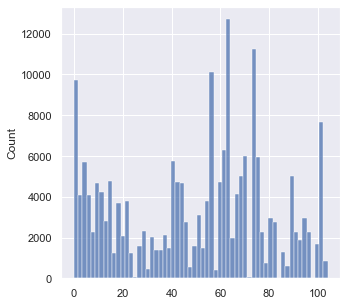

In [191]:
# filter docs with no topics
no_topic_index = np.sum(res, axis = (0)) > 0

sns.set(rc={'figure.figsize':(5,5)})

# for each document, what is the biggest topic?
sns.histplot(np.argmax(res[:,no_topic_index], axis = 0))

## Fit TSNE to the data

In [157]:
# tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.5, init='pca',perplexity=100, n_iter=5000)
# tsne_lda = tsne_model.fit_transform(res[:,no_topic_index].transpose())

#### Load tsne data ran in Roy

In [109]:
tsne_array = np.load('../results/fine-scale/all-countries/tsne_results.npy', allow_pickle = True)

In [223]:
tsne_array.item()["tsne_lda"][1][:,0].size

199553

In [211]:
df_meta_joined[no_topic_index]

# TSNE_ax_1 = np.random.uniform(size = (df_meta_joined.shape[0],2))

df_meta_joined["ax_1"] = TSNE_ax_1[:,0]
df_meta_joined["ax_2"] = TSNE_ax_1[:,1]

df_meta_joined

ProjectId Country CountryFundingBody  \
0       C863601C-4645-4020-914E-3C572106BB23      UK               UKRI   
1       73CCF222-0616-4CE8-8BFD-8738EBED8513      UK               UKRI   
2       17555E0B-B1D0-45E3-ABBC-568398B51F03      UK               UKRI   
3       460532CE-3455-4B06-BCED-E7E32BB4FB2F      UK               UKRI   
4       58B8C5C7-7230-465E-8254-12A4E6995207      UK               UKRI   
...                                      ...     ...                ...   
202219                               0542848     USA                NSF   
202220                               2023186     USA                NSF   
202221                               1948409     USA                NSF   
202222                               1714753     USA                NSF   
202223                               0223753     USA                NSF   

        CorpusId   docId   index FundingBody  \
0              0       0   37722         MRC   
1              1       1   90271       EPSRC   
2              2       2   82524         MRC   
3              3       3   73273         MRC   
4              4       4   33662        STFC   
...          ...     ...     ...         ...   
202219    202219  202219  143469         BIO   
202220    202220  202220  113074         GEO   
202221    202221  202221   96810         GEO   
202222    202222  202222   80064         GEO   
202223    202223  202223  149655         BIO   

                                   LeadInstitution   StartDate     EndDate  \
0                             University of Oxford  30/04/2013  29/04/2016   
1                        University of Southampton  10/01/2011  09/01/2015   
2          London Sch of Hygiene and Trop Medicine  26/01/2015  30/03/2017   
3                        University College London  30/09/2008  29/09/2010   
4                          University of Cambridge  08/03/2013  07/03/2015   
...                                            ...         ...         ...   
202219                          Cornell University  08/01/2006  07/31/2010   
202220                        University of Hawaii  09/01/2020  08/31/2023   
202221            Lamont Doherty Earth Observatory  03/15/2020  02/28/2023   
202222  University of Kentucky Research Foundation  08/01/2017  09/30/2018   
202223                 Gordon Research Conferences  06/01/2002  11/30/2002   

       FundingAmount FundingCurrency  TNSE_ax_1      ax_1      ax_2  
0          1274897.0             GBP   0.769535  0.480769  0.388893  
1           916817.0             GBP   0.911629  0.122186  0.178353  
2            50405.0             GBP   0.425059  0.155680  0.722104  
3           175851.0             GBP   0.610394  0.985639  0.088126  
4             9200.0             GBP   0.919318  0.664390  0.899898  
...              ...             ...        ...       ...       ...  
202219        465208             USD   0.503407  0.541288  0.375631  
202220        280844             USD   0.002694  0.434189  0.933375  
202221        473223             USD   0.582339  0.815383  0.678904  
202222        127122             USD   0.953044  0.692891  0.838211  
202223         25000             USD   0.816500  0.264778  0.210332  

[202224 rows x 15 columns]

## Add back to metadata

16.37hr / 20:00

In [212]:
#index to match removed docs 
index = [i for (i,v) in enumerate(no_topic_index) if v]

TSNE_df = pd.DataFrame(tsne_lda,columns=["ax1","ax2"], index = index)
TSNE_df["topic"] = np.argmax(res[:,no_topic_index], axis = 0)

TSNE_df.head()

ax1        ax2  topic
0  12.017550   6.333493      1
1  -1.039367 -12.994139     89
2  -7.722100  11.134741     91
3 -14.274050   0.101003     31
4 -10.576329  -6.447346     28

In [ ]:
df_meta.set_index("docId")

KeyError: "None of ['docId'] are in the columns"

In [ ]:
df_meta = TSNE_df.join(df_meta.set_index("docId"))



KeyError: "None of ['docId'] are in the columns"

In [26]:
df_meta = df_meta.assign(Funding = lambda x : x.FundingAmount.astype(float) * ((x.FundingCurrency == "USD") * 0.82 + (x.FundingCurrency != "USD")))
df_meta["log10_funding"] = np.log10(np.maximum(np.exp(0), df_meta.Funding))


ValueError: could not convert string to float: 'None'

In [ ]:
# ## Topics that are almost all NSF

# # df_meta_topic_prop = df_meta.query("FundingBody != 'NSF'")
# df_meta_topic_prop = df_meta.groupby(["topic","FundingBody"]).size().reset_index()
# df_meta_topic_prop = df_meta_topic_prop.rename(columns={0:"N"})

# #funding body weight
# N_body = df_meta_topic_prop.groupby("FundingBody").apply(lambda x : sum(x["N"])).reset_index()
# N_body = N_body.rename(columns = {0 : "N_body"})
# N_body["N_body"] = N_body["N_body"] / sum(N_body["N_body"])

# # #calculate sums
# N_topic = df_meta_topic_prop.groupby("topic").apply(lambda x : sum(x["N"])).reset_index()
# N_topic = N_topic.rename(columns = {0 : "N_topic"})


# df_meta_topic_prop = df_meta_topic_prop.set_index("topic").join(N_topic.set_index("topic")).reset_index()
# df_meta_topic_prop = df_meta_topic_prop.set_index("FundingBody").join(N_body.set_index("FundingBody")).reset_index()

# df_meta_topic_prop = df_meta_topic_prop.assign(expected = lambda x : x.N_topic * x.N_body)
# df_meta_topic_prop["diff"] = (df_meta_topic_prop["N"] - df_meta_topic_prop["expected"]) / df_meta_topic_prop["expected"]

# df_topics = df_meta_topic_prop.query("FundingBody == 'NERC' & diff > 2").reset_index()

# # df_meta_topic_prop.query("topic == 0")

# df_topics

In [ ]:
# # set(NSF_topics.topic)

# topic_df.loc(0)[df_topics.topic]

# Research council distance matrix

To get distance of research councils we:
1) Calculate distance in topic space of each pair of documents (might need to sample if too large...)
2) Calculate summary of distances within and between research councils


In [175]:
# lda.minimum_probability = 0.01

# # topics 
# N = len(corpus)
# res = np.zeros((lda.num_topics, N))

# for i in range(0,N):
#     topic_probs = lda.get_document_topics(corpus[i])
#     for j in topic_probs:
#         res[j[0],i] = j[1]

In [68]:
import random

## Distance measure
def Hellinger(p, q):
    # distance between p an d
    # p and q are np array probability distributions
    n = len(p)
    sum = 0.0
    for i in range(n):
        sum += (np.sqrt(p[i]) - np.sqrt(q[i]))**2
    result = (1.0 / np.sqrt(2.0)) * np.sqrt(sum)
    return result


In [69]:
df_meta_joined.groupby('FundingBody').size()

FundingBody
BBSRC     7894
BIO      28726
ENG      34486
EPSRC    14776
GEO      34523
MPS      52214
MRC       6797
NERC      6437
STFC      3349
TIP      13022
dtype: int64

In [79]:
# get number of documents from res array
df_meta_filter = df_meta_joined.groupby('FundingBody').filter(lambda x : len(x) > 3000)
funders = df_meta_filter["FundingBody"].unique()

N = len(funders)
N_sample = 3300

# create empty array to store distances by using the number of existing documents
Hellinger_distance = np.zeros((N,N,N_sample))
# Cosine_distance = np.zeros((N,N,N_sample))
#Shannon_distance = np.zeros((N,N,N_sample))
# Wasserstein_distance = np.zeros((N,N,N_sample))


# for loop to allocate distances to the distances array
# for every document in N
for i in range(N):
    # and for each document in the top right triangle
    for j in range(i, N):
        #get samples
        indx_1 = df_meta_filter[df_meta_filter.FundingBody == funders[i]].index
        indx_2 = df_meta_filter[df_meta_filter.FundingBody == funders[j]].index
        
        print(i ," ", funders[i]," ",j," ",funders[j])
        
        indx_1 = random.sample(sorted(indx_1), N_sample)
        indx_2 = random.sample(sorted(indx_2), N_sample)
        for a, (k,l) in enumerate(zip(indx_1,indx_2)):
           
        # calculate Hellinger distance of probability of one document to another for all topics
            dis = Hellinger(res[:,k], res[:,l])
            Hellinger_distance[i,j,a] = Hellinger_distance[j,i,a] = dis
            
#             dis = scipy.spatial.distance.cosine(res[:,k], res[:,l])
#             Cosine_distance[i,j,a] = Cosine_distance[j,i,a] = dis
            
            # dis = scipy.spatial.distance.jensenshannon(res[:,k], res[:,l])
            # Shannon_distance[i,j,a] = Shannon_distance[j,i,a] = dis
            
#             dis = scipy.stats.wasserstein_distance(res[:,k], res[:,l])
#             Wasserstein_distance[i,j,a] = Wasserstein_distance[j,i,a] = dis
        

0   MRC   0   MRC
0   MRC   1   EPSRC
0   MRC   2   STFC
0   MRC   3   NERC
0   MRC   4   BBSRC
0   MRC   5   ENG
0   MRC   6   MPS
0   MRC   7   GEO
0   MRC   8   BIO
0   MRC   9   TIP
1   EPSRC   1   EPSRC
1   EPSRC   2   STFC
1   EPSRC   3   NERC
1   EPSRC   4   BBSRC
1   EPSRC   5   ENG
1   EPSRC   6   MPS
1   EPSRC   7   GEO
1   EPSRC   8   BIO
1   EPSRC   9   TIP
2   STFC   2   STFC
2   STFC   3   NERC
2   STFC   4   BBSRC
2   STFC   5   ENG
2   STFC   6   MPS
2   STFC   7   GEO
2   STFC   8   BIO
2   STFC   9   TIP
3   NERC   3   NERC
3   NERC   4   BBSRC
3   NERC   5   ENG
3   NERC   6   MPS
3   NERC   7   GEO
3   NERC   8   BIO
3   NERC   9   TIP
4   BBSRC   4   BBSRC
4   BBSRC   5   ENG
4   BBSRC   6   MPS
4   BBSRC   7   GEO
4   BBSRC   8   BIO
4   BBSRC   9   TIP
5   ENG   5   ENG
5   ENG   6   MPS
5   ENG   7   GEO
5   ENG   8   BIO
5   ENG   9   TIP
6   MPS   6   MPS
6   MPS   7   GEO
6   MPS   8   BIO
6   MPS   9   TIP
7   GEO   7   GEO
7   GEO   8   BIO
7   GEO   9   TI

In [100]:
mean_hell = np.nanmean(Hellinger_distance, axis = (2))

mean_hell

array([[0.75766426, 0.86132904, 0.83748341, 0.87527031, 0.82446023,
        0.88202652, 0.88082017, 0.88268511, 0.87402799, 0.86778862],
       [0.86132904, 0.87763923, 0.85221405, 0.89409456, 0.88238259,
        0.89270752, 0.88904078, 0.89639557, 0.90100027, 0.89206201],
       [0.83748341, 0.85221405, 0.76622291, 0.8637439 , 0.84951064,
        0.86731593, 0.84997605, 0.86282622, 0.86771497, 0.8660672 ],
       [0.87527031, 0.89409456, 0.8637439 , 0.86362352, 0.88428204,
        0.91005977, 0.90926582, 0.88009279, 0.89523596, 0.90912106],
       [0.82446023, 0.88238259, 0.84951064, 0.88428204, 0.82189288,
        0.89246176, 0.88924446, 0.89126824, 0.86485815, 0.88666044],
       [0.88202652, 0.89270752, 0.86731593, 0.91005977, 0.89246176,
        0.8949806 , 0.8954891 , 0.90291914, 0.90593155, 0.90072041],
       [0.88082017, 0.88904078, 0.84997605, 0.90926582, 0.88924446,
        0.8954891 , 0.86819167, 0.90330754, 0.90325721, 0.90475578],
       [0.88268511, 0.89639557, 0.8628262

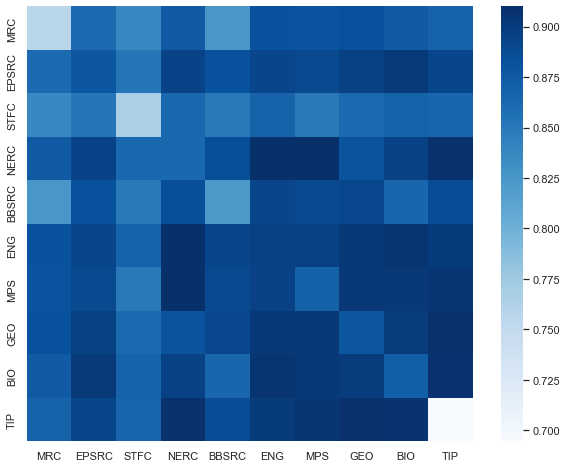

In [94]:
sns.set(rc={'figure.figsize':(10,8)})

#fig, axs = plt.subplots(1,0)

a = sns.heatmap(np.nanmean(Hellinger_distance, axis = (2)), xticklabels=funders, yticklabels=funders, cmap = "Blues")
#sns.heatmap(np.nanmean(Shannon_distance, axis = (2)), ax=axs[1], xticklabels=funders,yticklabels=funders,cmap = "Blues").set(title='Jensen-Shannon')

# plt.savefig('../results/fine-scale/figures/heatmap_distances_by_funding_body_UK_USA.png')

In [32]:
Hellinger_distance[-1,:]

array([[0.91057966, 0.921063  , 0.89021363, ..., 0.91401121, 0.89980935,
        0.88085817],
       [0.91401627, 0.90461083, 0.92352417, ..., 0.91368715, 0.66077338,
        0.91729237],
       [0.93200841, 0.64244259, 0.93066768, ..., 0.92363026, 0.92041851,
        0.91643175],
       ...,
       [0.91685789, 0.91314773, 0.90671075, ..., 0.92372574, 0.89710042,
        0.91971367],
       [0.9214056 , 0.89385471, 0.93425107, ..., 0.9344854 , 0.92616134,
        0.92166832],
       [0.89825058, 0.91541855, 0.91264519, ..., 0.90148315, 0.92343673,
        0.90953308]])

In [ ]:
# get number of documents from res array
df_meta_filter = df_meta.groupby('LeadUniversity').filter(lambda x : len(x) > 2800)
funders = df_meta_filter["LeadUniversity"].unique()

N = len(funders)
N_sample = 1000

# create empty array to store distances by using the number of existing documents
distance_mat = np.zeros((N,N,N_sample,4,2))

# for loop to allocate distances to the distances array
# for every document in N
for i in range(N):
    # and for each document in the top right triangle
    for j in range(i, N):
        #get samples
        indx_1 = df_meta_filter[df_meta_filter.LeadUniversity == funders[i]].index
        indx_2 = df_meta_filter[df_meta_filter.LeadUniversity == funders[j]].index
        
        print(len(indx_1), len(indx_2))
        
        indx_1 = random.sample(sorted(indx_1), N_sample)
        indx_2 = random.sample(sorted(indx_2), N_sample)
        
        for a, (k,l) in enumerate(zip(indx_1,indx_2)):
           # calculate Hellinger distance of probability of one document to another for all topics
            dis = Hellinger(res[:,k], res[:,l])
            distance_mat[i,j,a,0,0] = Hellinger_distance[j,i,a] = dis
            
            dis = scipy.spatial.distance.cosine(res[:,k], res[:,l])
            distance_mat[i,j,a,1,0] = Cosine_distance[j,i,a] = dis
            
            dis = scipy.spatial.distance.jensenshannon(res[:,k], res[:,l])
            distance_mat[i,j,a,2,0] = Shannon_distance[j,i,a] = dis
            
            dis = scipy.stats.wasserstein_distance(res[:,k], res[:,l])
            distance_mat[i,j,a,3,0] = Wasserstein_distance[j,i,a] = dis
 

/opt/homebrew/Caskroom/miniconda/base/envs/Funding-Landscape/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/opt/homebrew/Caskroom/miniconda/base/envs/Funding-Landscape/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/homebrew/Caskroom/miniconda/base/envs/Funding-Landscape/lib/python3.9/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
/opt/homebrew/Caskroom/miniconda/base/envs/Funding-Landscape/lib/python3.9/site-packages/seaborn/matrix.py:312: MatplotlibDeprecationWarning: Aut

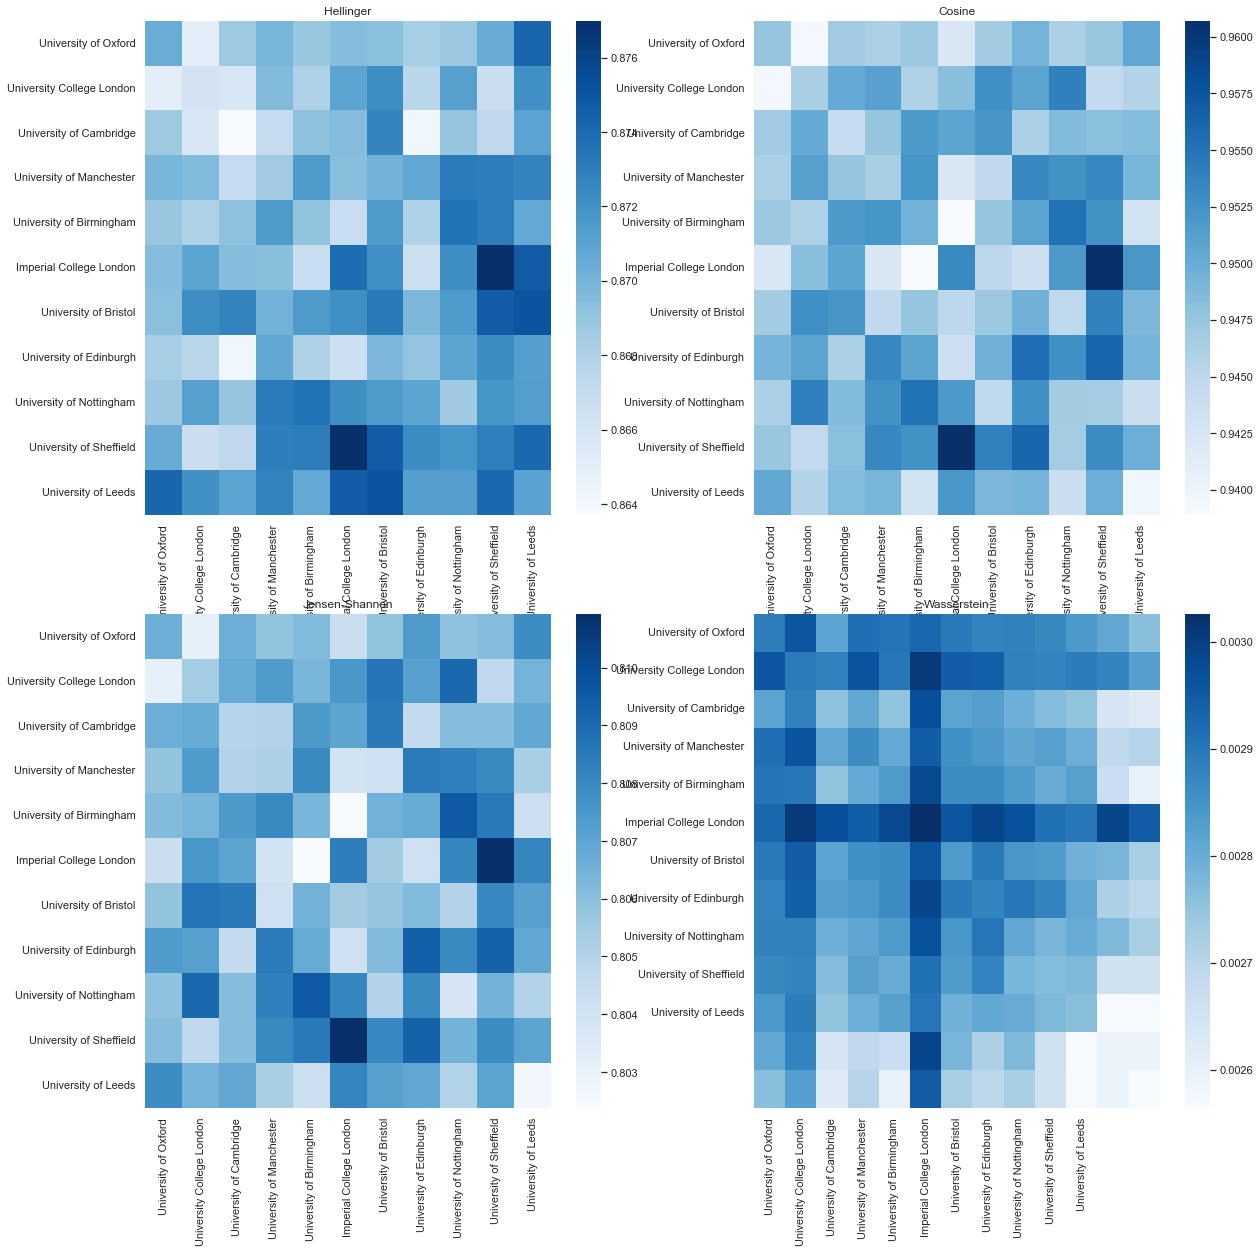

In [218]:
sns.set(rc={'figure.figsize':(20,20)})


fig, axs = plt.subplots(2,2)

sns.heatmap(np.nanmean(Hellinger_distance, axis = (2)), ax=axs[0,0],xticklabels=funders,yticklabels=funders, cmap = "Blues").set(title='Hellinger')
sns.heatmap(np.nanmean(Cosine_distance, axis = (2)), ax=axs[0,1], xticklabels=funders,yticklabels=funders,cmap = "Blues").set(title='Cosine')
sns.heatmap(np.nanmean(Shannon_distance, axis = (2)), ax=axs[1,0], xticklabels=funders,yticklabels=funders,cmap = "Blues").set(title='Jensen-Shannon')
sns.heatmap(np.nanmean(Wasserstein_distance, axis = (2)), ax=axs[1,1], xticklabels=funders,yticklabels=funders,cmap = "Blues").set(title='Wasserstein')

plt.savefig('../results/fine-scale/figures/heatmap_distances_by_universities.png')